### The iris dataset

The Iris dataset is perhaps the most widely used dataset in machine learning. Primarily useful for its simple but interesting data.

Here we present a PCA of the dataset along with a few other visualizations, showing its 3 clusters.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

iris = load_iris()

df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                    columns= iris['feature_names'] + ['target'])
y = df['target'].astype('int') #save the target labas because we don't want to normalize them

X = df.drop(['target'], axis=1).apply(lambda x: (x - np.mean(x)) / np.std(x))

X.tail()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
145,1.038005,-0.124958,0.819624,1.447956
146,0.553333,-1.281972,0.705893,0.922064
147,0.795669,-0.124958,0.819624,1.053537
148,0.432165,0.800654,0.933356,1.447956
149,0.068662,-0.124958,0.762759,0.790591


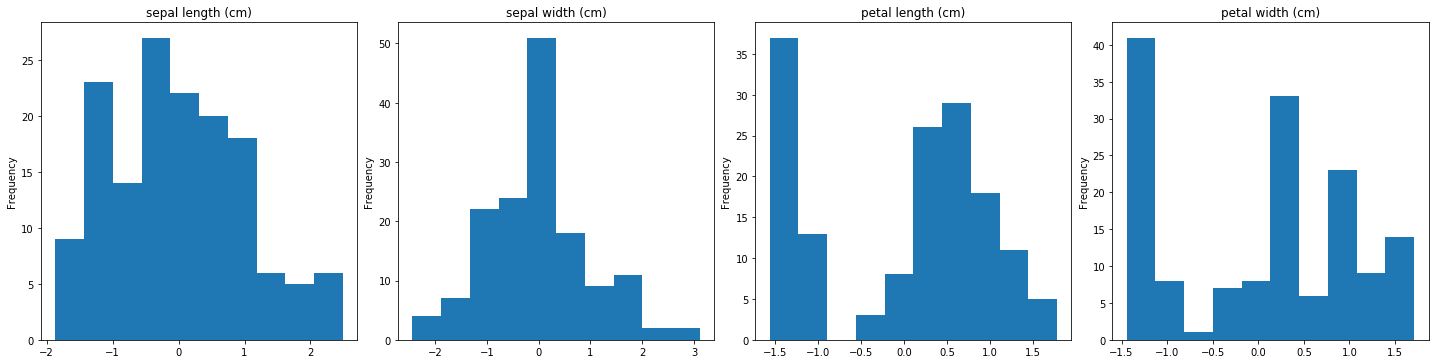

In [17]:
import matplotlib.pyplot as plt
import math

cols = len(X.columns)
fig, axs = plt.subplots(1, cols)
fig.set_size_inches(20, 5)
plt.tight_layout(w_pad=1)

for i, col in enumerate(X.columns):
    ax = axs[i]
    ax.set_title(col)
    X[col].plot.hist(ax = ax)

plt.show()

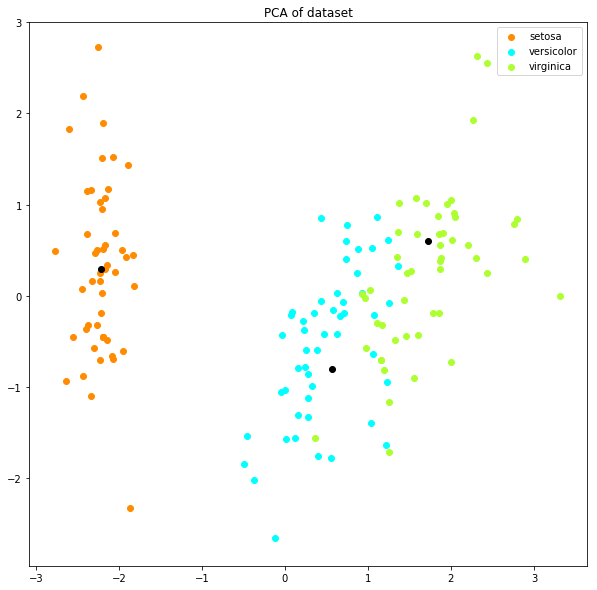

In [5]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pca = PCA(n_components=2).fit(X)
X_r = pca.transform(X)

means = KMeans(n_clusters=3).fit(X_r).cluster_centers_

plt.figure(figsize=(10,10))
colors = ['darkorange', 'cyan', 'greenyellow']

for i, name in enumerate(iris.target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], color=colors[i], label=name)
    
plt.scatter(means[:,0], means[:,1], color='black')

plt.legend(loc='best', shadow=False)
plt.title('PCA of dataset')

plt.show()

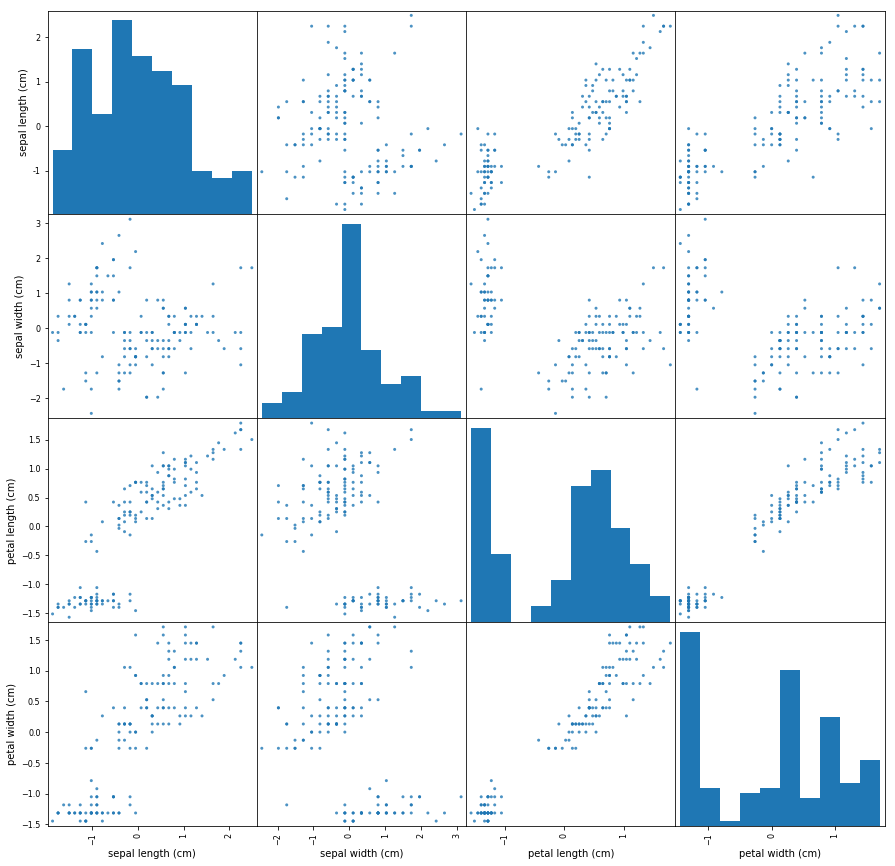

In [6]:
pd.plotting.scatter_matrix(X, figsize=(15,15), alpha=0.8)
plt.show()

## Test sets

TODO:
- description of why test sets are important
- brief description of paper's description of how to choose test set size:
- For errors independently and identically distributed (i.i.d), a rule of thumb is to use n = 100/p, where n is the test set size and p is the error rate of the best recognizer, as estimated, for instance, by the human error rate. (guyon, 1998)
- Assume our error rate will be 5%, that gives us target number of 2000 samples, which is not possible with this small of a dataset
- we will examine the consequences of this issue at the end

Select a test set here

## Train/validation split graph

This graph shows the relative accuracy ((TP + TN) / # samples) of two classifiers, a k-nearest neighbors classifier and a support vector machine, over the training set size percentage of the data.

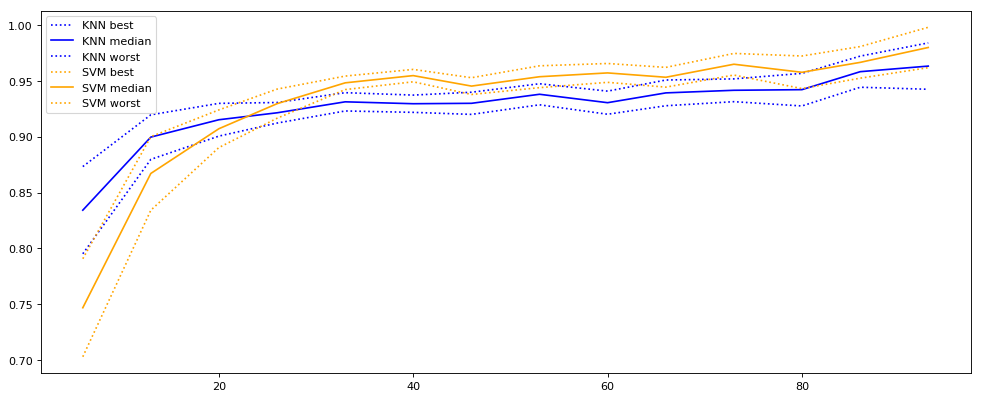

In [115]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import scipy.stats as st

def maxConfidenceInterval(in_vec):
    return st.t.interval(0.95, len(in_vec)-1, loc=np.mean(in_vec), scale=st.sem(in_vec))[1]

def minConfidenceInterval(in_vec):
    return st.t.interval(0.95, len(in_vec)-1, loc=np.mean(in_vec), scale=st.sem(in_vec))[0]

num_samples = X.shape[0]
indexes = np.arange(num_samples)
num_runs = 30
step_size = 10
start_num = 10
classifier1 = KNeighborsClassifier(n_neighbors=1)
classifier2 = SVC()

results1 = []
results2 = []

for train_size in range(start_num, num_samples, step_size):
    val_size = num_samples - train_size
    accuracies1 = []
    accuracies2 = []
    for i in range(num_runs):
        samples = np.random.choice(indexes, size=train_size, replace=False)

        X_train = X.loc[samples]
        X_val = X.drop(X_train.index)
        
        y_train = y.loc[samples]
        y_val = y.drop(y_train.index)
        
        classifier1.fit(X_train, y_train)
        classifier2.fit(X_train, y_train)
        
        accuracy1 = (classifier1.predict(X_val) == y_val).sum() / val_size
        accuracy2 = (classifier2.predict(X_val) == y_val).sum() / val_size
        
        accuracies1.append(accuracy1)
        accuracies2.append(accuracy2)
        
    results1.append(accuracies1)
    results2.append(accuracies2)

plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
idx = range(start_num, num_samples, step_size)
pct = [int((x / num_samples) * 100) for x in idx]

plt.plot(pct, np.apply_along_axis(maxConfidenceInterval, 1, results1), color='blue', linestyle=':')
plt.plot(pct, np.apply_along_axis(np.mean, 1, results1), color='blue')
plt.plot(pct, np.apply_along_axis(minConfidenceInterval, 1, results1), color='blue', linestyle=':')

plt.plot(pct, np.apply_along_axis(maxConfidenceInterval, 1, results2), color='orange', linestyle=':')
plt.plot(pct, np.apply_along_axis(np.mean, 1, results2), color='orange')
plt.plot(pct, np.apply_along_axis(minConfidenceInterval, 1, results2), color='orange', linestyle=':')

plt.legend(['KNN best', 'KNN median', 'KNN worst', 'SVM best', 'SVM median', 'SVM worst'])
plt.show()

### What this shows:

We can see from the above graph that while SVM performs better than KNN, the difference becomes blurry at the two extremes:
- With too little training data, we see that the KNN approach can classify more effectively with little data, but this is irrelevant because we have much more data that we will eventually train with.
- With too little validation data, the confidence intervals begin to overlap since there is too much random variation from the small number of validation samples.

Therefore, our goal is to find the omptimal balance between these two extremes.

### A scaling law for the train/validate set size ratio

According to Guyon, there is a simple law to follow when deciding how to split your training and validation sets (Guyon, 1996):
\begin{align}
\frac{f}{g} = \sqrt{\frac{C * ln(N / \alpha^2)}{h_{max}}}
\end{align}

Where f is the validation set size, g is the training set size, C is a constant (usually ~ 1.5), N is the number of families of classifiers we are comparing, alpha is our desired confidence interval (usually 0.05), and h_max is the largest complexity of the models we are comparing.

h_max is a value that is determined for curve fitting. This variable describes the complexity of the model we are training, and Guyon leaves its definition intentionally vague. In our example we will use h_max = 50 as an arbitrary, reasonable value (TODO: Discuss if this is a good assumption, how to calculate value).

Therefore, for this example, we will use: g = 70% of the data. With more complex models, this number will increase (because the larger number of training examples is more important to avoid overfitting) and with less complex models, this number will decrease (because the increased number of examples becomes less important than the variability in the final tests).

f/g = sqrt(1.5*ln(2/(.05^2))/50)


1. Guyon, Isabelle. (1996). "A Scaling Law for the Validation-Set Training-Set Size Ratio." AT&T Bell Lab.. 1. .
2. Guyon, Isabelle., et al. “What Size Test Set Gives Good Error Rate Estimates?” IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 20, no. 1, 1998, pp. 52–64., doi:10.1109/34.655649.

### TODO:
- Run cross validation on validation set, discuss pros and cons
- use test set to estimate error, and show methods of comparing performance on test sets
- compare several different classifiers that have been optimized on a validation set using a test set.

## Overall TODOs (discuss where to put these):
Run cross validation on validation set, discuss pros and cons
use test set to estimate error, and show methods of comparing performance on test sets
compare several different classifiers that have been optimized on a validation set using a test set.
### Questions:
How does the work look so far?
I think, in order to use a proper test set, that I need to use different data (More data points). Is there one you recommend? Should I go with generated data?